In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
from torchvision.models import resnet18
import torchaudio.transforms as T
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')
data_dir = '/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings'

In [4]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [5]:
NUM_SAMPLES = 11022
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
random_seed = 15
train_size = 0.8

In [6]:
recordings_old = sorted(os.listdir(data_dir))

In [7]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [8]:
len(recordings)

2903

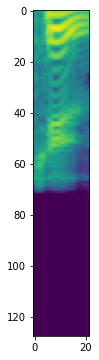

In [9]:
y, _ = librosa.load(data_dir + '/' + recordings[700], sr = sr)
samples = y[:NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec, ref=np.max)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [10]:
image_size = melspec.shape
image_size

(128, 22)

In [11]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def freq_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = 0.0
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = 0.0
    return image

def random_erasing(image, max_a = 12, max_b = 2):
    a = np.random.randint(max_a)
    b = np.random.randint(max_b)
    a0 = np.random.randint(image.shape[1] - a)
    b0 = np.random.randint(image.shape[2] - b)
    image[:, a0 : a0 + a, b0 : b0 + b] = 0.0
    return image

def loudness_conrol(image):
    min_value = torch.min(image)
    lyambda = np.random.rand() * 0.4
    image = min_value + lyambda * (image - min_value)
    return image
    
def FreqNoising(image, var = 0.1, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(image.shape[1] - a)
    noise = var * torch.randn(a, image.shape[2])
    image[0, a0: a0 + a, :] += noise
    image[1, a0: a0 + a, :] += noise
    image[2, a0: a0 + a, :] += noise
    return image

def TimeNoising(image, var = 0.1, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(image.shape[2] - b)
    noise = var * torch.randn(image.shape[1], b)
    image[0, :, b0: b0 + b] += noise
    image[1, :, b0: b0 + b] += noise
    image[2, :, b0: b0 + b] += noise
    return image

def TimeCycleShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def FreqCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, image.shape[1] - shift:, :].clone()
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = t
    else:
        t = image[:, :shift, :].clone()
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = t
    return image

def TimeSpecialShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
    return image

def FreqSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
    return image

def FreqSwapAugmentation(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - a)
    t = image[:, a0 : a0 + a, :].clone()
    image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    image[:, a0 - a: a0, :] = t
    return image

def TimeSwapAugmentation(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def FreqReplyMasking(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - 2 * a)
    p = np.random.rand()
    if p < 0.5:
        image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    else:
        image[:,  a0 : a0 + a, :] = image[:, a0 + a : a0 + 2 * a, :]
    return image

def TimeReplyMasking(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 2):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def FreqRandomSwap(image, max_a = 12):
    a = np.random.randint(max_a)
    a1 = np.random.randint(image.shape[1] - a)
    while True:
        a2 = np.random.randint(image.shape[1] - a)
        if np.abs(a1 - a2) >= a:
            t = image[:, a1 : a1 + a, :].clone()
            image[:, a1 : a1 + a, :] = image[:, a2 : a2 + a, :]
            image[:, a2 : a2 + a, :] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(2)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(12)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 12, 2)
    if mode == 'FreqShift':
        return freq_shift_augmentation(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'LoudnessControl':
        return loudness_conrol(image)
    if mode == 'TimeNoising':
        return TimeNoising(image)
    if mode == 'FreqNoising':
        return FreqNoising(image)
    if mode == 'FreqCycleShift':
        return FreqCycleShift(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'FreqSpecialShift':
        return FreqSpecialShift(image)
    if mode == 'TimeSpecialShift':
        return TimeSpecialShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'FreqSwapAugmentation':
        return FreqSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'FreqReplyMasking':
        return FreqReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'FreqRandomSwap':
        return FreqRandomSwap(image)
    
    
    return image

In [12]:
def get_spectrogram(filename):
    y, _ = librosa.load(filename, sr = sr)
    samples = y[:NUM_SAMPLES]
    melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
    melspec = librosa.power_to_db(melspec)
    melspec = normalize(melspec, mean=None, std=None)
    return torch.tensor(melspec, dtype=torch.float32)

In [13]:
data = []
labels = []
for i in range(len(recordings)):
    data.append(get_spectrogram(data_dir + '/' + recordings[i]))
    labels.append(int(recordings[i][0]))

In [14]:
keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

In [15]:
class AudioMNIST(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = [], augment = False, aug_type = 'No'):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        self.augment = augment
        self.aug_type = aug_type
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        if self.augment:
            X = augmentation(X, self.aug_type)
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, augment = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    for epoch in range(epochs):
        print('epoch:', epoch)
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)

        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        print('Train')
        print(mean_loss)

        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)

        print('TEST')
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        print('loss:', mean_loss)
        print('accuracy:', mean_accuracy)
        print('******************')
    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_acc

In [17]:
def evaluate(model, test_loader):
    model.eval()
    #all_preds = []
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)
            #all_preds.append(preds)

    mean_accuracy = sum_accuracy / cnt_objects
    print('Quality of the model')
    print('accuracy:', mean_accuracy)

## Resnet18

### No augmentation

In [18]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = False, keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch: 0
Train
0.9846298921859322
TEST
loss: 0.5394561731687156
accuracy: 0.8064516129032258
******************
epoch: 1
Train
0.3630892582073222
TEST
loss: 0.3664260609816479
accuracy: 0.8946236559139785
******************
epoch: 2
Train
0.27205534422981786
TEST
loss: 0.804063888647223
accuracy: 0.7935483870967742
******************
epoch: 3
Train
0.2659416178188211
TEST
loss: 0.5512640789631874
accuracy: 0.8408602150537634
******************
epoch: 4
Train
0.18543128917213403
TEST
loss: 0.3590264952310952
accuracy: 0.9032258064516129
******************
epoch: 5
Train
0.18507285654448538
TEST
loss: 0.823691406942183
accuracy: 0.8086021505376344
******************
epoch: 6
Train
0.13627134850093223
TEST
loss: 0.22667234611286913
accuracy: 0.946236559139785
******************
epoch: 7
Train
0.13019654653890195
TEST
loss: 0.27097596974783045
accuracy: 0.9333333333333333
******************
epoch: 8
Train
0.07882275953527798
TEST
loss: 0.23451672858127984
accuracy: 0.9354838709677419
*****

In [19]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9621342512908778


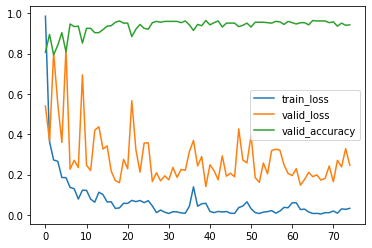

In [20]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeMasking

In [21]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.0529281187904864
TEST
loss: 1.0813714529878349
accuracy: 0.7096774193548387
******************
epoch: 1
Train
0.35574793494640017
TEST
loss: 0.5149663658552273
accuracy: 0.8602150537634409
******************
epoch: 2
Train
0.29299805853786687
TEST
loss: 0.6348514715189575
accuracy: 0.821505376344086
******************
epoch: 3
Train
0.28042386203410485
TEST
loss: 0.34560500306467856
accuracy: 0.875268817204301
******************
epoch: 4
Train
0.18619066653356928
TEST
loss: 0.24617911923316219
accuracy: 0.9268817204301075
******************
epoch: 5
Train
0.1592318237822866
TEST
loss: 0.22297192110169317
accuracy: 0.9290322580645162
******************
epoch: 6
Train
0.10872389103737838
TEST
loss: 0.22768492629771592
accuracy: 0.9311827956989247
******************
epoch: 7
Train
0.16382988141904803
TEST
loss: 0.27151665218094345
accuracy: 0.9247311827956989
******************
epoch: 8
Train
0.19624505799883593
TEST
loss: 0.37304443185047437

In [22]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9414802065404475


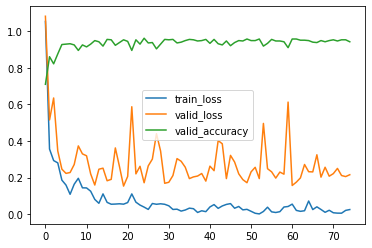

In [23]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqMasking

In [24]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.1085121198951011
TEST
loss: 0.7565377014939503
accuracy: 0.7870967741935484
******************
epoch: 1
Train
0.45424597303136804
TEST
loss: 0.33770822895470487
accuracy: 0.8709677419354839
******************
epoch: 2
Train
0.32749464595966205
TEST
loss: 0.5504460198263968
accuracy: 0.8365591397849462
******************
epoch: 3
Train
0.3065597393465222
TEST
loss: 0.3767948788340374
accuracy: 0.8903225806451613
******************
epoch: 4
Train
0.26683632044876915
TEST
loss: 0.6862209517468688
accuracy: 0.810752688172043
******************
epoch: 5
Train
0.20481317609500424
TEST
loss: 0.19059295925882555
accuracy: 0.946236559139785
******************
epoch: 6
Train
0.17877251881149164
TEST
loss: 0.27439240415891014
accuracy: 0.9247311827956989
******************
epoch: 7
Train
0.15498403903131017
TEST
loss: 0.22196205495506205
accuracy: 0.9376344086021505
******************
epoch: 8
Train
0.13232008780628104
TEST
loss: 0.18661784178787663


In [25]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9604130808950087


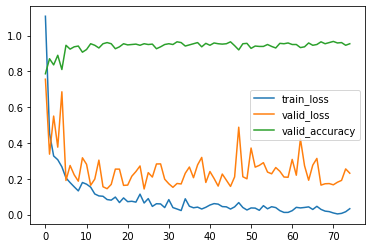

In [26]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### Noise

In [27]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'Noise', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.02236384708649
TEST
loss: 0.8076827074891777
accuracy: 0.7741935483870968
******************
epoch: 1
Train
0.3869652434196534
TEST
loss: 0.6752581038782673
accuracy: 0.821505376344086
******************
epoch: 2
Train
0.28492044189249754
TEST
loss: 0.3329476219672029
accuracy: 0.896774193548387
******************
epoch: 3
Train
0.20575047726905918
TEST
loss: 0.31243649913418675
accuracy: 0.9161290322580645
******************
epoch: 4
Train
0.17352870859378244
TEST
loss: 0.3882124594462815
accuracy: 0.9010752688172043
******************
epoch: 5
Train
0.1905003569671141
TEST
loss: 0.27285073822544464
accuracy: 0.9053763440860215
******************
epoch: 6
Train
0.15163494074415249
TEST
loss: 0.3921096291593326
accuracy: 0.875268817204301
******************
epoch: 7
Train
0.1225130354918391
TEST
loss: 0.3871817018396111
accuracy: 0.886021505376344
******************
epoch: 8
Train
0.1471258175424433
TEST
loss: 0.2012323231466355
accuracy: 

In [28]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9655765920826161


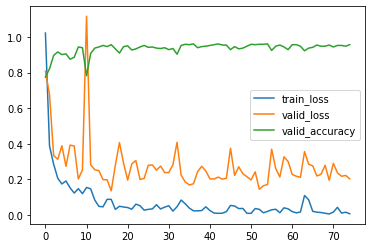

In [29]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### RandomErasing

In [30]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'RandomErasing', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.9337561425818637
TEST
loss: 0.39836435779448476
accuracy: 0.8688172043010752
******************
epoch: 1
Train
0.3598964868467472
TEST
loss: 1.4120248822755712
accuracy: 0.7526881720430108
******************
epoch: 2
Train
0.34263198922639515
TEST
loss: 0.7568008169051139
accuracy: 0.7956989247311828
******************
epoch: 3
Train
0.2141012965702022
TEST
loss: 0.4200072334658715
accuracy: 0.8903225806451613
******************
epoch: 4
Train
0.18220276568098998
TEST
loss: 0.34438071520097796
accuracy: 0.9204301075268817
******************
epoch: 5
Train
0.164017558691639
TEST
loss: 0.1751617056708182
accuracy: 0.9526881720430107
******************
epoch: 6
Train
0.13742744661847558
TEST
loss: 0.31540445034862846
accuracy: 0.8989247311827957
******************
epoch: 7
Train
0.13701650907932975
TEST
loss: 0.1894420765420442
accuracy: 0.9483870967741935
******************
epoch: 8
Train
0.09367313819767392
TEST
loss: 0.21229560839873488
ac

In [31]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9621342512908778


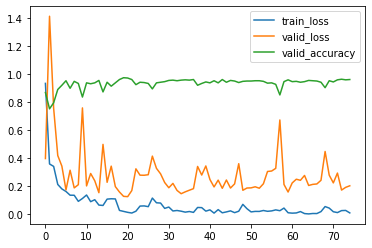

In [32]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeShift

In [33]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.0564388964339233
TEST
loss: 0.6994387566402395
accuracy: 0.8129032258064516
******************
epoch: 1
Train
0.4078584537752611
TEST
loss: 0.40074175923101363
accuracy: 0.8473118279569892
******************
epoch: 2
Train
0.3046082262076161
TEST
loss: 0.4760037758017099
accuracy: 0.8731182795698925
******************
epoch: 3
Train
0.3113806234230325
TEST
loss: 0.6136727463494065
accuracy: 0.8559139784946237
******************
epoch: 4
Train
0.23227621768197515
TEST
loss: 0.2317490251474483
accuracy: 0.9247311827956989
******************
epoch: 5
Train
0.19709634939765314
TEST
loss: 0.32446776910494735
accuracy: 0.896774193548387
******************
epoch: 6
Train
0.1844378799906198
TEST
loss: 0.21052345598256716
accuracy: 0.9354838709677419
******************
epoch: 7
Train
0.15219311522070156
TEST
loss: 0.25581196094712905
accuracy: 0.9096774193548387
******************
epoch: 8
Train
0.1583989372995507
TEST
loss: 0.19627440328239112
acc

In [34]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9604130808950087


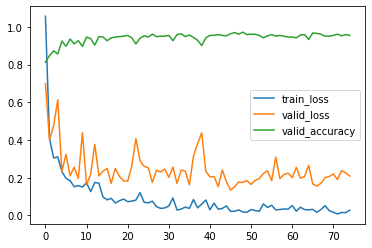

In [35]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqShift

In [36]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.827240573120939
TEST
loss: 2.0438837876883884
accuracy: 0.535483870967742
******************
epoch: 1
Train
1.3285135932679966
TEST
loss: 1.1718190690522552
accuracy: 0.6666666666666666
******************
epoch: 2
Train
1.238228446511601
TEST
loss: 0.6590257859999133
accuracy: 0.8064516129032258
******************
epoch: 3
Train
1.0966014084022535
TEST
loss: 0.723249791642671
accuracy: 0.7698924731182796
******************
epoch: 4
Train
1.0381687041823429
TEST
loss: 0.712441010116249
accuracy: 0.8301075268817204
******************
epoch: 5
Train
1.0049130042265613
TEST
loss: 0.5039244339030277
accuracy: 0.8451612903225807
******************
epoch: 6
Train
0.9774721615020473
TEST
loss: 0.392541132819268
accuracy: 0.8795698924731182
******************
epoch: 7
Train
0.9391586435181387
TEST
loss: 0.5170082681922502
accuracy: 0.8494623655913979
******************
epoch: 8
Train
0.920252772384134
TEST
loss: 0.3913526209131364
accuracy: 0.89892

In [37]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9432013769363167


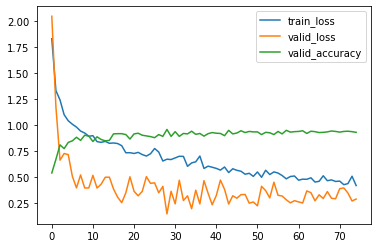

In [38]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### LoudnessControl

In [39]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'LoudnessControl', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.5043397743212772
TEST
loss: 1.1007178060470089
accuracy: 0.6430107526881721
******************
epoch: 1
Train
0.7182292795720508
TEST
loss: 0.5656914868662434
accuracy: 0.8236559139784946
******************
epoch: 2
Train
0.5429023296908788
TEST
loss: 1.1523041089375814
accuracy: 0.6946236559139785
******************
epoch: 3
Train
0.41443606724839216
TEST
loss: 0.600915345966175
accuracy: 0.7806451612903226
******************
epoch: 4
Train
0.3529083969840839
TEST
loss: 0.3693076778483647
accuracy: 0.8838709677419355
******************
epoch: 5
Train
0.3132244047132563
TEST
loss: 0.5860010630340986
accuracy: 0.810752688172043
******************
epoch: 6
Train
0.2839543585117363
TEST
loss: 0.43166957862915534
accuracy: 0.8666666666666667
******************
epoch: 7
Train
0.2630599169687488
TEST
loss: 0.9584856689617198
accuracy: 0.7698924731182796
******************
epoch: 8
Train
0.23570341680662313
TEST
loss: 0.284829093579964
accuracy: 

In [40]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9242685025817556


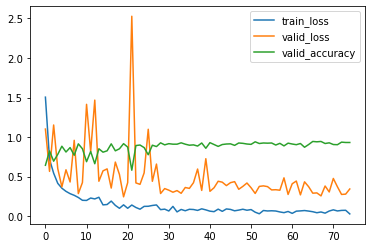

In [41]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeNoising

In [42]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.9871194922416905
TEST
loss: 0.7538512058155511
accuracy: 0.7720430107526882
******************
epoch: 1
Train
0.3615337274507226
TEST
loss: 0.4155809606916161
accuracy: 0.8817204301075269
******************
epoch: 2
Train
0.22519621119809907
TEST
loss: 0.25773023533564743
accuracy: 0.9182795698924732
******************
epoch: 3
Train
0.21560619547602047
TEST
loss: 0.7732843381102367
accuracy: 0.7698924731182796
******************
epoch: 4
Train
0.2347148550924076
TEST
loss: 0.34025298709510476
accuracy: 0.9075268817204301
******************
epoch: 5
Train
0.16937629832782344
TEST
loss: 0.2295322863645451
accuracy: 0.9225806451612903
******************
epoch: 6
Train
0.13483060980651992
TEST
loss: 0.30874370150668645
accuracy: 0.9118279569892473
******************
epoch: 7
Train
0.11999664815542964
TEST
loss: 0.2896737155734852
accuracy: 0.9204301075268817
******************
epoch: 8
Train
0.09829902766080845
TEST
loss: 0.9573280504954759
a

In [43]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9604130808950087


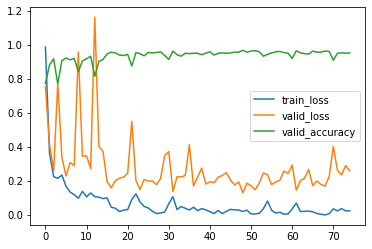

In [44]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqNoising

In [45]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.9929870517907377
TEST
loss: 0.8823195729204404
accuracy: 0.7698924731182796
******************
epoch: 1
Train
0.3595478416580504
TEST
loss: 1.0455136074814746
accuracy: 0.7440860215053764
******************
epoch: 2
Train
0.29701684576629245
TEST
loss: 0.3995315556885094
accuracy: 0.8731182795698925
******************
epoch: 3
Train
0.19621014309365967
TEST
loss: 0.5210255353681503
accuracy: 0.8666666666666667
******************
epoch: 4
Train
0.16180832219431973
TEST
loss: 0.32987711468050557
accuracy: 0.9139784946236559
******************
epoch: 5
Train
0.2509632597832379
TEST
loss: 0.7063415977262681
accuracy: 0.8258064516129032
******************
epoch: 6
Train
0.21697759500709218
TEST
loss: 0.36490810010381924
accuracy: 0.8881720430107527
******************
epoch: 7
Train
0.14179823139565056
TEST
loss: 0.17460753957750977
accuracy: 0.946236559139785
******************
epoch: 8
Train
0.11478272867607185
TEST
loss: 0.4139194269334116
ac

In [46]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9569707401032702


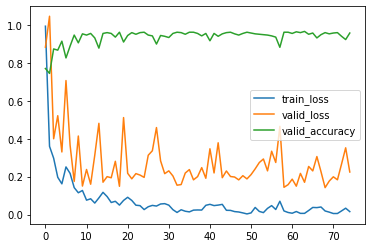

In [47]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeCycleShift

In [48]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.0354681854679435
TEST
loss: 0.8478143961198868
accuracy: 0.7440860215053764
******************
epoch: 1
Train
0.43316131839844635
TEST
loss: 0.4830342126149003
accuracy: 0.8279569892473119
******************
epoch: 2
Train
0.31033363917468376
TEST
loss: 0.7265724861493674
accuracy: 0.821505376344086
******************
epoch: 3
Train
0.2771667425004654
TEST
loss: 0.40437163691366873
accuracy: 0.8580645161290322
******************
epoch: 4
Train
0.24177201056133757
TEST
loss: 0.20244846856722268
accuracy: 0.9268817204301075
******************
epoch: 5
Train
0.18496393557993007
TEST
loss: 0.2575624612069899
accuracy: 0.9204301075268817
******************
epoch: 6
Train
0.23546969034399598
TEST
loss: 0.8169687963942046
accuracy: 0.8387096774193549
******************
epoch: 7
Train
0.2165270437780862
TEST
loss: 0.2378244508338231
accuracy: 0.9182795698924732
******************
epoch: 8
Train
0.1457658930369199
TEST
loss: 0.2060028924096015
accu

In [49]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


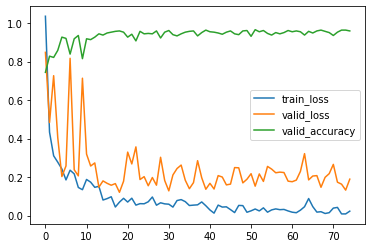

In [50]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqCycleShift

In [51]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.800882266552524
TEST
loss: 1.1671995070672805
accuracy: 0.6838709677419355
******************
epoch: 1
Train
1.3299100770061865
TEST
loss: 1.089345057036287
accuracy: 0.7161290322580646
******************
epoch: 2
Train
1.3003038483148759
TEST
loss: 0.6395424691579675
accuracy: 0.7935483870967742
******************
epoch: 3
Train
1.1015962958656849
TEST
loss: 0.4316495155775419
accuracy: 0.8494623655913979
******************
epoch: 4
Train
1.0245550953706362
TEST
loss: 0.3680665321247552
accuracy: 0.8838709677419355
******************
epoch: 5
Train
0.9773558879579083
TEST
loss: 0.5337993962790376
accuracy: 0.8301075268817204
******************
epoch: 6
Train
0.9459798269266715
TEST
loss: 0.2598022215468909
accuracy: 0.9182795698924732
******************
epoch: 7
Train
0.8938847109394557
TEST
loss: 0.6472958076384759
accuracy: 0.8193548387096774
******************
epoch: 8
Train
0.9050739955439899
TEST
loss: 0.3708066198133653
accuracy: 0.

In [52]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9449225473321858


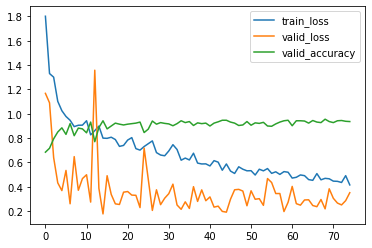

In [53]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSpecialShift

In [54]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.0017496708842715
TEST
loss: 0.4923910931874347
accuracy: 0.8494623655913979
******************
epoch: 1
Train
0.4052389866572654
TEST
loss: 0.6424429551247628
accuracy: 0.8129032258064516
******************
epoch: 2
Train
0.32842598175835597
TEST
loss: 0.7850183158792475
accuracy: 0.8
******************
epoch: 3
Train
0.26166577203079905
TEST
loss: 0.26934373598265393
accuracy: 0.9075268817204301
******************
epoch: 4
Train
0.24148143300717403
TEST
loss: 0.2294786802863562
accuracy: 0.9311827956989247
******************
epoch: 5
Train
0.17457100645502088
TEST
loss: 0.3142690400282542
accuracy: 0.8946236559139785
******************
epoch: 6
Train
0.1626665991162766
TEST
loss: 0.3680008414451794
accuracy: 0.8924731182795699
******************
epoch: 7
Train
0.14887247939118148
TEST
loss: 0.3059332993882959
accuracy: 0.9225806451612903
******************
epoch: 8
Train
0.14377459650984617
TEST
loss: 0.23733013797831792
accuracy: 0.92473

In [55]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9707401032702238


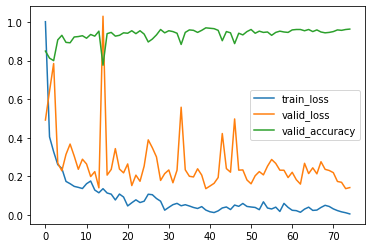

In [56]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSpecialShift

In [57]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.8866027496678892
TEST
loss: 1.4828866210035099
accuracy: 0.6236559139784946
******************
epoch: 1
Train
1.43240322435037
TEST
loss: 0.8571898266833315
accuracy: 0.6989247311827957
******************
epoch: 2
Train
1.274594660015856
TEST
loss: 0.5111321376216027
accuracy: 0.832258064516129
******************
epoch: 3
Train
1.1477585387088691
TEST
loss: 0.5422042612106569
accuracy: 0.8301075268817204
******************
epoch: 4
Train
1.0639836507005338
TEST
loss: 0.49276819472671834
accuracy: 0.8365591397849462
******************
epoch: 5
Train
1.054835869602189
TEST
loss: 0.705713350285766
accuracy: 0.7419354838709677
******************
epoch: 6
Train
0.9800029869161759
TEST
loss: 0.3478565820442733
accuracy: 0.8903225806451613
******************
epoch: 7
Train
0.8964641675810436
TEST
loss: 0.4746489122990639
accuracy: 0.8709677419354839
******************
epoch: 8
Train
0.9442436811932968
TEST
loss: 0.4921406248564361
accuracy: 0.860

In [58]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9414802065404475


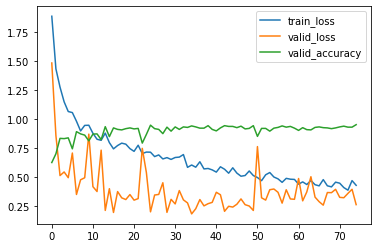

In [59]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSwapAugmentation

In [60]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.9460094369863655
TEST
loss: 0.7004554886971751
accuracy: 0.8021505376344086
******************
epoch: 1
Train
0.36121413318714146
TEST
loss: 0.5159853322531587
accuracy: 0.8494623655913979
******************
epoch: 2
Train
0.3305198768806766
TEST
loss: 0.63087865742304
accuracy: 0.8172043010752689
******************
epoch: 3
Train
0.24639753333714678
TEST
loss: 0.38293814133572324
accuracy: 0.8881720430107527
******************
epoch: 4
Train
0.1660370397259615
TEST
loss: 0.24774363646584172
accuracy: 0.9247311827956989
******************
epoch: 5
Train
0.1554803149910081
TEST
loss: 0.2845634771290646
accuracy: 0.9053763440860215
******************
epoch: 6
Train
0.14870966487054102
TEST
loss: 0.35363742074658794
accuracy: 0.9032258064516129
******************
epoch: 7
Train
0.1540260887075382
TEST
loss: 0.2449542211909448
accuracy: 0.9376344086021505
******************
epoch: 8
Train
0.08484867496810167
TEST
loss: 0.16189118323306884
accu

In [61]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9518072289156626


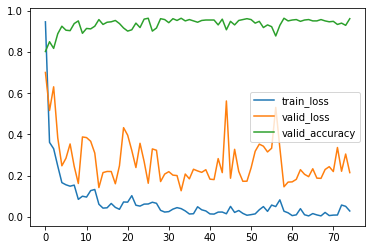

In [62]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSwapAugmentation

In [63]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.0369068822619347
TEST
loss: 1.3437337378019927
accuracy: 0.6795698924731183
******************
epoch: 1
Train
0.4962110667056657
TEST
loss: 0.483226248141258
accuracy: 0.832258064516129
******************
epoch: 2
Train
0.40906676709427264
TEST
loss: 0.5437606562850296
accuracy: 0.8451612903225807
******************
epoch: 3
Train
0.27982919814449264
TEST
loss: 0.4650237254558071
accuracy: 0.8623655913978494
******************
epoch: 4
Train
0.29189879456449724
TEST
loss: 0.8666095795169954
accuracy: 0.8301075268817204
******************
epoch: 5
Train
0.19395854541160243
TEST
loss: 0.20609516389267418
accuracy: 0.9397849462365592
******************
epoch: 6
Train
0.19427936718742503
TEST
loss: 0.49798726932976833
accuracy: 0.8838709677419355
******************
epoch: 7
Train
0.21444136552677145
TEST
loss: 0.24648673262006493
accuracy: 0.9268817204301075
******************
epoch: 8
Train
0.19944785401329407
TEST
loss: 0.22369991766829644
a

In [64]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9500860585197934


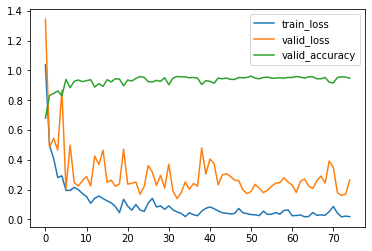

In [65]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeReplyMasking

In [66]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.9611371567509928
TEST
loss: 0.8089238336009364
accuracy: 0.7720430107526882
******************
epoch: 1
Train
0.36248845879467956
TEST
loss: 0.325913875558043
accuracy: 0.886021505376344
******************
epoch: 2
Train
0.29407020673099615
TEST
loss: 1.346158625746286
accuracy: 0.7419354838709677
******************
epoch: 3
Train
0.23319437382486988
TEST
loss: 0.3850678771734238
accuracy: 0.9096774193548387
******************
epoch: 4
Train
0.17478605137920278
TEST
loss: 0.23515609534837867
accuracy: 0.9354838709677419
******************
epoch: 5
Train
0.19095109466525517
TEST
loss: 0.22320162826968779
accuracy: 0.9376344086021505
******************
epoch: 6
Train
0.1568397493229544
TEST
loss: 0.22763603518727005
accuracy: 0.9225806451612903
******************
epoch: 7
Train
0.11310137288347007
TEST
loss: 0.28593301952526134
accuracy: 0.9419354838709677
******************
epoch: 8
Train
0.08010614473587348
TEST
loss: 0.20228725043676232
a

In [67]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9535283993115319


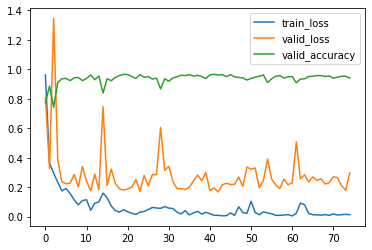

In [68]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqReplyMasking

In [69]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.998820138991874
TEST
loss: 0.637614683822919
accuracy: 0.8021505376344086
******************
epoch: 1
Train
0.4044881389548076
TEST
loss: 0.3746802906836233
accuracy: 0.8688172043010752
******************
epoch: 2
Train
0.33572942297755226
TEST
loss: 0.4063953325953535
accuracy: 0.8666666666666667
******************
epoch: 3
Train
0.2530591840312631
TEST
loss: 0.3952015182984773
accuracy: 0.8946236559139785
******************
epoch: 4
Train
0.288940987281409
TEST
loss: 0.24777484228534083
accuracy: 0.9247311827956989
******************
epoch: 5
Train
0.20306906906519773
TEST
loss: 0.18562818349048654
accuracy: 0.9397849462365592
******************
epoch: 6
Train
0.18482346963548635
TEST
loss: 0.24777533527343504
accuracy: 0.9419354838709677
******************
epoch: 7
Train
0.1618174592140354
TEST
loss: 0.3695819510567573
accuracy: 0.9010752688172043
******************
epoch: 8
Train
0.1441646921872194
TEST
loss: 0.17031085404657548
accura

In [70]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9535283993115319


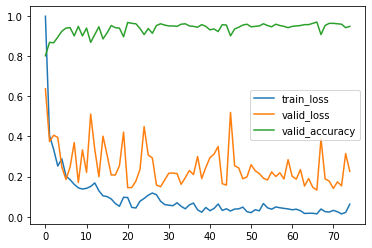

In [71]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeRandomSwap

In [72]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.0319257735178942
TEST
loss: 0.7567784018413994
accuracy: 0.8064516129032258
******************
epoch: 1
Train
0.4120017242611385
TEST
loss: 0.7100150818465858
accuracy: 0.8086021505376344
******************
epoch: 2
Train
0.30910966199896445
TEST
loss: 0.4972209175427755
accuracy: 0.8494623655913979
******************
epoch: 3
Train
0.19558679784698774
TEST
loss: 0.2576410039778679
accuracy: 0.9075268817204301
******************
epoch: 4
Train
0.22779558253147042
TEST
loss: 0.3046312184103074
accuracy: 0.9032258064516129
******************
epoch: 5
Train
0.19913369648290952
TEST
loss: 0.2518772155366918
accuracy: 0.9161290322580645
******************
epoch: 6
Train
0.18620491401765318
TEST
loss: 0.1797193030356079
accuracy: 0.9376344086021505
******************
epoch: 7
Train
0.1143938298159122
TEST
loss: 0.3386213790344936
accuracy: 0.9053763440860215
******************
epoch: 8
Train
0.12884744218619332
TEST
loss: 0.2636455234660897
accu

In [73]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9690189328743546


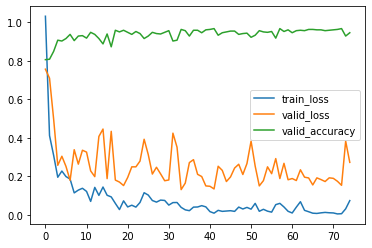

In [74]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqRandomSwap

In [75]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.3002750656588076
TEST
loss: 1.2792970775276102
accuracy: 0.6731182795698925
******************
epoch: 1
Train
0.5774320183611712
TEST
loss: 0.4397639016951284
accuracy: 0.8666666666666667
******************
epoch: 2
Train
0.4596993891089978
TEST
loss: 0.49765894348903367
accuracy: 0.8451612903225807
******************
epoch: 3
Train
0.36187057759598756
TEST
loss: 0.5238818517295263
accuracy: 0.853763440860215
******************
epoch: 4
Train
0.372600754551433
TEST
loss: 0.3558414697647095
accuracy: 0.8903225806451613
******************
epoch: 5
Train
0.32137912978840955
TEST
loss: 0.6201644280905365
accuracy: 0.843010752688172
******************
epoch: 6
Train
0.29609941120229877
TEST
loss: 0.31083005500096145
accuracy: 0.8817204301075269
******************
epoch: 7
Train
0.24382370620500546
TEST
loss: 0.21483497613219804
accuracy: 0.9376344086021505
******************
epoch: 8
Train
0.1859953195643027
TEST
loss: 0.2822958241226853
accura

In [76]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9569707401032702


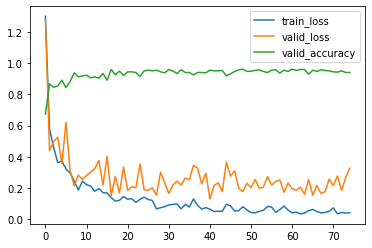

In [77]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()